In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

# Data location

In [5]:
data_path = "data/clean_data.csv"

# Load data

In [6]:
df = pd.read_csv(data_path)

In [7]:
df

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448.0,1.0,195.0,39.0,106.0,70.0,0.0,0.0,26.970,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
1,2448.0,1.0,209.0,52.0,121.0,66.0,0.0,0.0,27.794,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
2,6238.0,2.0,250.0,46.0,121.0,81.0,0.0,0.0,28.730,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
3,6238.0,2.0,260.0,52.0,105.0,70.0,0.0,0.0,29.430,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
4,6238.0,2.0,237.0,58.0,108.0,66.0,0.0,0.0,28.500,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,9998212.0,1.0,173.0,46.0,126.0,82.0,0.0,0.0,19.170,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11623,9998212.0,1.0,153.0,52.0,143.0,89.0,0.0,0.0,25.740,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11624,9999312.0,2.0,196.0,39.0,133.0,86.0,1.0,30.0,20.910,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0
11625,9999312.0,2.0,240.0,46.0,138.0,79.0,1.0,20.0,26.390,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0


In [8]:
df.shape

(11627, 39)

In [9]:
df['HDLC']

0        45.0
1        31.0
2        45.0
3        45.0
4        54.0
         ... 
11622    52.0
11623    30.0
11624    52.0
11625    52.0
11626    52.0
Name: HDLC, Length: 11627, dtype: float64

In [10]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [11]:
df.iloc[:, 1: 23].columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC'],
      dtype='object')

In [12]:
df.iloc[:, 23: 31].columns

Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
       'HYPERTEN'],
      dtype='object')

In [13]:
print(df.iloc[:, 1: 23].shape[1], df.iloc[:, 23: 31].shape[1])

22 8


# Node class

In [14]:
class Node():
    def __init__(self, left=None, right=None, information_gain=None,
                 threshold=None, column_name=None, column_index=None, operator=None, value=None):
        
        #children
        self.left = left  
        self.right = right
        
        #decision node
        self.information_gain = information_gain
        self.threshold = threshold
        self.column_name = column_name
        self.column_index = column_index
        self.operator = operator
        
        #leef node
        self.value = value

# Tree class

In [15]:
class DecisionTree():
    def __init__(self, min_participant=2, max_depth=2):
        self.column_names = {}
        self.root = None
        
        self.min_participant = min_participant
        self.max_depth = max_depth
        
        self.x_col_names=None
        
    def split_input_label(self, dataset):
        return dataset[:, :22], dataset[:, 22:]

    def build_tree(self, dataset, depth=0):
        #print(depth)
        count_participant, _ = np.shape(dataset)
        
        if count_participant >= self.min_participant and depth <= self.max_depth:
            split = self.get_split_value(dataset)
            if split['information_gain'] > 0 :
                left = self.build_tree(split['left'], depth=depth + 1)
                right = self.build_tree(split['right'], depth=depth + 1)
                
                if left.value != None and right.value != None and left.value == right.value:
                    return Node(value=left.value)

                return Node(left, right, split['information_gain'],
                            split['threshold'], split['column_name'], split['column_index'], split['operator'])
        
        leaf_value = self.compute_leaf_value(dataset)
        return Node(value=leaf_value)
    
    def get_split_value(self, dataset):
        max_gain = float('-inf')
        split = {}
        
        inputs, labels = self.split_input_label(dataset)

        columns = len(self.x_col_names)

        for i, column in enumerate(self.x_col_names):
        
            binary_col = False
            col = dataset[:, i]
            possible_thresholds = np.unique(col)
            
            if len(possible_thresholds) == 2:
                binary_col = True
            else:
                possible_thresholds = possible_thresholds[1:-1]
                
            #print("possible_thre", possible_thresholds)
            
            for threshold in possible_thresholds:
                left, right = self.split(dataset, threshold, i, binary_col)
                gain = self.compute_information_gain(dataset, left, right)
                
                if gain > max_gain:
                    max_gain = gain
                    split['information_gain'] = gain
                    split['threshold'] = threshold
                    split['left'] = left
                    split['right'] = right
                    split['column_name'] = column
                    split['column_index'] = i
                    split['operator'] = "=" if binary_col else "<="
                if binary_col:
                    break
        #print("gain", gain, split)
        return split
    
    def split(self, dataset, threshold, column_index, binary_col):
        if binary_col:
            left = dataset[np.where(dataset[:, column_index] == threshold)]
            right = dataset[np.where(dataset[:, column_index] != threshold)]
        else:
            left = dataset[np.where(dataset[:, column_index] <= threshold)]
            right = dataset[np.where(dataset[:, column_index] > threshold)]
        
        return left, right
    
    def compute_information_gain(self, dataset, left, right):
        inputs, labels = self.split_input_label(dataset)
        left_inputs, left_labels = self.split_input_label(left)
        right_inputs, right_labels = self.split_input_label(right)
        
        weight_left = len(left) / len(dataset)
        weight_right = len(right) / len(dataset)
        
        childs_entropy = self.entropy(left_labels) * weight_left + self.entropy(right_labels) * weight_right
        
        information_gain = self.entropy(labels) - childs_entropy
        
        return information_gain
    
    def entropy(self, labels):
        res = 0
        for value in [0, 1]: #possible values
            value_proportion = len(labels[labels == value]) / len(labels)
            if value_proportion != 0:
                res += -value_proportion * np.log2(value_proportion)
        return res
    
    def compute_leaf_value(self, dataset):
        inputs, labels = self.split_input_label(dataset)
        
        values, counts = np.unique(labels, return_counts=True)

        index = np.argmax(counts)
        return values[index]
        
    def fit(self, X, Y, x_col_names):
        dataset = np.concatenate((X, Y), axis=1)
        self.x_col_names = x_col_names
        self.root = self.build_tree(dataset)
        
    def evaluate(self, x, decision_tree):
        #leaf
        if decision_tree.value != None:
            return decision_tree.value

        x_column_value = x[decision_tree.column_index]

        if x_column_value <= decision_tree.threshold:
            return self.evaluate(x, decision_tree.left)
        return self.evaluate(x, decision_tree.right)
    
    def predict(self, X):
        return [self.evaluate(x, self.root) for x in X]
    
    def predict_one_element(self, X):
        return [self.evaluate(x, self.root)]
    
    def pretty_print(self, information_gain=True, tiret="|---"):
        if self.root == None:
            print("No tree, please use the fit method")
            return
        
        self.pretty_print_node(self.root)
        
    def pretty_print_node(self, node, information_gain=True, tiret="|---"):
        if node.value != None:
            print(tiret, "value", node.value)
            return

        print(tiret, node.column_name, node.operator, node.threshold, end=' ')
        
        if node.left.value != None and node.right.value != None:
            print("value", node.left.value , "else", node.right.value)
            return
        if node.left.value != None:
            print("value", node.left.value)
            self.pretty_print_node(node.right, tiret=tiret+"|---")
            return
        
        if node.right.value != None:
            print("else ", node.right.value)
            self.pretty_print_node(node.left, tiret=tiret+"|---")
            return
        print()
            
        self.pretty_print_node(node.left, tiret=tiret+"|---")
        self.pretty_print_node(node.right, tiret=tiret+"|---")

# Confusion matrix

In [16]:
# Confusion matrix 

def prediction_analyse(X_test, Y_test):
    
    
    Y_pred = decision_tree.predict(X_test) 

    print("accuracy ==>", accuracy_score(Y_test.flatten(), Y_pred))
    
    #print(all_predictions)
    cm = confusion_matrix(Y_test.flatten(), Y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()
    
    
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatif

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    #positive predictive value
    PPV = TP / (TP + FP)
    #negative predictive value
    NPV = TN / (TN + FN)


    print(f'sensitivity : {sensitivity}, specificity : {specificity}, PPV : {PPV}, NPV : {NPV}')

# Split data set into train, validation and test

In [17]:
data = np.loadtxt(data_path, delimiter=",",dtype=float, skiprows=1)
col_names = np.genfromtxt(data_path , delimiter=',', names=True, dtype=float).dtype.names[1:31]
x_col_names = col_names[0:22]
y_col_names = col_names[22:30]

X = data[:, 1:23]
Y = data[:, 29:30]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


# Depth

In [18]:
DEPTH = 5

# DEATH


## * Train

In [19]:
Y = data[:, 24:25]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)
print(Y)
print(X_train.shape)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(9301, 22)


In [20]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [21]:
decision_tree.pretty_print()

|--- PREVAP = 0.0 else  1.0
|---|--- BMI <= 25.1 
|---|---|--- TOTCHOL <= 224.0 
|---|---|---|--- TOTCHOL <= 163.0 value 0.0
|---|---|---|---|--- SYSBP <= 190.0 value 0.0
|---|---|---|---|---|--- SYSBP <= 196.0 value 1.0 else 0.0
|---|---|---|--- PREVCHD = 0.0 value 0.0
|---|---|---|---|--- AGE <= 73.0 value 0.0 else 1.0
|---|---|--- TOTCHOL <= 202.0 
|---|---|---|--- GLUCOSE <= 320.0 value 0.0 else 1.0
|---|---|---|--- HDLC <= 52.0 value 0.0
|---|---|---|---|--- BMI <= 42.53 value 0.0
|---|---|---|---|---|--- SYSBP <= 160.0 value 0.0 else 1.0


## * Test

accuracy ==> 0.8907996560619088


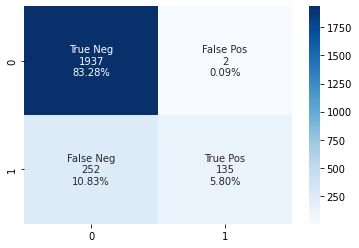

sensitivity : 0.3488372093023256, specificity : 0.998968540484786, PPV : 0.9854014598540146, NPV : 0.8848789401553221


In [22]:
prediction_analyse(X_test, Y_test)

# ANGINA

## * Train

In [24]:
Y = data[:, 25:26]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


In [25]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [26]:
decision_tree.pretty_print()

|--- PREVMI = 0.0 
|---|--- SEX = 1.0 
|---|---|--- PREVCHD = 0.0 
|---|---|---|--- TOTCHOL <= 203.0 else  0.0
|---|---|---|---|--- TIME <= 4326.0 value 0.0
|---|---|---|---|---|--- DIABP <= 110.0 value 0.0 else 1.0
|---|---|---|--- TOTCHOL <= 268.0 
|---|---|---|---|--- AGE <= 51.0 else  0.0
|---|---|---|---|---|--- GLUCOSE <= 70.0 value 0.0 else 1.0
|---|---|---|---|--- TOTCHOL <= 294.0 else  0.0
|---|---|---|---|---|--- SYSBP <= 120.0 value 0.0 else 1.0
|---|---|--- SYSBP <= 143.0 
|---|---|---|--- TOTCHOL <= 237.0 value 0.0
|---|---|---|---|--- TOTCHOL <= 430.0 value 0.0 else 1.0
|---|---|---|--- SYSBP <= 187.0 value 0.0
|---|---|---|---|--- HEARTRTE <= 75.0 else  0.0
|---|---|---|---|---|--- AGE <= 50.0 value 1.0 else 0.0
|---|--- SEX = 1.0 
|---|---|--- PREVHYP = 0.0 
|---|---|---|--- HDLC <= 35.0 else  1.0
|---|---|---|---|--- SYSBP <= 119.0 value 0.0 else 1.0
|---|---|---|--- HEARTRTE <= 73.0 
|---|---|---|---|--- AGE <= 71.0 value 1.0
|---|---|---|---|---|--- PREVAP = 0.0 valu

## * Test

accuracy ==> 0.9200172006020211


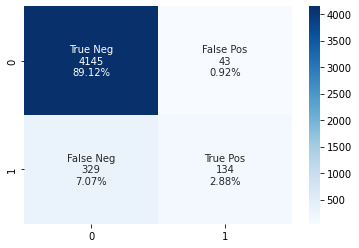

sensitivity : 0.2894168466522678, specificity : 0.9897325692454633, PPV : 0.7570621468926554, NPV : 0.9264640143048726


In [27]:
prediction_analyse(X_test, Y_test)

# HOSPMI

## * Train

In [28]:
Y = data[:, 26:27]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


In [29]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [30]:
decision_tree.pretty_print()

|--- PREVCHD = 0.0 
|---|--- SEX = 1.0 
|---|---|--- SYSBP <= 144.0 
|---|---|---|--- TOTCHOL <= 210.0 
|---|---|---|---|--- GLUCOSE <= 175.0 value 0.0 else 1.0
|---|---|---|---|--- TIME <= 2219.0 else  0.0
|---|---|---|---|---|--- GLUCOSE <= 123.0 value 0.0 else 1.0
|---|---|---|--- LDLC <= 124.0 else  0.0
|---|---|---|---|--- TIME <= 4403.0 value 0.0
|---|---|---|---|---|--- TIME <= 4460.0 value 1.0 else 0.0
|---|---|--- SYSBP <= 143.0 
|---|---|---|--- TOTCHOL <= 253.0 value 0.0
|---|---|---|---|--- TOTCHOL <= 341.0 value 0.0
|---|---|---|---|---|--- LDLC <= 170.0 value 1.0 else 0.0
|---|---|---|--- SYSBP <= 172.0 else  0.0
|---|---|---|---|--- TOTCHOL <= 290.0 value 0.0
|---|---|---|---|---|--- DIABP <= 70.0 value 1.0 else 0.0
|---|--- PREVMI = 0.0 
|---|---|--- SEX = 1.0 
|---|---|---|--- HDLC <= 57.0 else  0.0
|---|---|---|---|--- DIABP <= 90.0 else  1.0
|---|---|---|---|---|--- GLUCOSE <= 84.0 value 0.0 else 1.0
|---|---|---|--- DIABP <= 88.0 value 0.0
|---|---|---|---|--- educ 

## * Test

accuracy ==> 0.8615351537303806


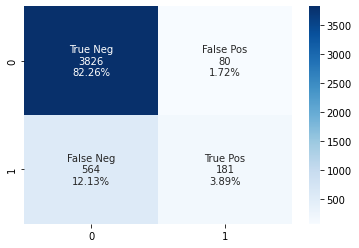

sensitivity : 0.24295302013422818, specificity : 0.9795186891961085, PPV : 0.6934865900383141, NPV : 0.8715261958997722


In [31]:
prediction_analyse(X_test, Y_test)

# MI_FCHD

## * Train

In [32]:
Y = data[:, 27:28]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


In [33]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [34]:
decision_tree.pretty_print()

|--- PREVCHD = 0.0 else  1.0
|---|--- SEX = 1.0 
|---|---|--- SYSBP <= 134.0 
|---|---|---|--- TOTCHOL <= 224.0 
|---|---|---|---|--- DIABETES = 0.0 value 0.0
|---|---|---|---|---|--- TOTCHOL <= 213.0 value 1.0 else 0.0
|---|---|---|---|--- TIME <= 4263.0 else  0.0
|---|---|---|---|---|--- GLUCOSE <= 105.0 value 0.0 else 1.0
|---|---|---|--- BMI <= 26.08 value 0.0
|---|---|---|---|--- TIME <= 2171.0 else  0.0
|---|---|---|---|---|--- TOTCHOL <= 283.0 value 0.0 else 1.0
|---|---|--- SYSBP <= 143.0 
|---|---|---|--- TOTCHOL <= 226.0 value 0.0
|---|---|---|---|--- HDLC <= 41.0 else  0.0
|---|---|---|---|---|--- BMI <= 32.6 value 0.0 else 1.0
|---|---|---|--- SYSBP <= 171.0 value 0.0
|---|---|---|---|--- BMI <= 44.71 value 0.0 else 1.0


## * Test

accuracy ==> 0.8000430015050527


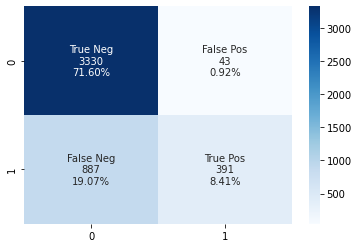

sensitivity : 0.3059467918622848, specificity : 0.9872517047139046, PPV : 0.9009216589861752, NPV : 0.7896608963718283


In [35]:
prediction_analyse(X_test, Y_test)

# ANY_CHD

## * Train

In [36]:
Y = data[:, 28:29]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


In [37]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [38]:
decision_tree.pretty_print()

|--- PREVSTRK = 0.0 else  1.0
|---|--- AGE <= 55.0 
|---|---|--- SYSBP <= 136.0 
|---|---|---|--- CIGPDAY <= 2.0 else  0.0
|---|---|---|---|--- BMI <= 26.43 value 0.0
|---|---|---|---|---|--- DIABP <= 100.0 value 0.0 else 1.0
|---|---|---|--- TIME <= 2176.0 else  0.0
|---|---|---|---|--- HDLC <= 72.0 value 0.0
|---|---|---|---|---|--- SEX = 1.0 value 0.0 else 1.0
|---|---|--- SYSBP <= 164.0 value 0.0
|---|---|---|--- TIME <= 2165.0 
|---|---|---|---|--- DIABP <= 105.0 
|---|---|---|---|---|--- TIME <= 2157.0 value 0.0 else 1.0
|---|---|---|---|---|--- BMI <= 35.22 value 0.0 else 1.0
|---|---|---|---|--- SYSBP <= 207.0 
|---|---|---|---|---|--- HDLC <= 27.0 value 1.0 else 0.0
|---|---|---|---|---|--- TIME <= 4387.0 value 0.0 else 1.0


## * Test

accuracy ==> 0.9213072457536013


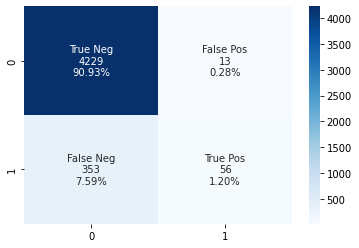

sensitivity : 0.13691931540342298, specificity : 0.9969354078264969, PPV : 0.8115942028985508, NPV : 0.922959406372763


In [39]:
prediction_analyse(X_test, Y_test)

# STROKE

## * Train

In [40]:
Y = data[:, 29:30]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(6976, 22)


In [41]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [42]:
decision_tree.pretty_print()

|--- PREVMI = 0.0 
|---|--- SYSBP <= 135.0 
|---|---|--- SEX = 1.0 
|---|---|---|--- AGE <= 54.0 
|---|---|---|---|--- TOTCHOL <= 208.0 else  0.0
|---|---|---|---|---|--- GLUCOSE <= 143.0 value 0.0 else 1.0
|---|---|---|---|--- TIME <= 2267.0 value 0.0
|---|---|---|---|---|--- PREVAP = 0.0 value 0.0 else 1.0
|---|---|---|--- PREVSTRK = 0.0 value 0.0 else 1.0
|---|---|--- PREVSTRK = 0.0 else  1.0
|---|---|---|--- SEX = 1.0 else  0.0
|---|---|---|---|--- AGE <= 53.0 value 0.0
|---|---|---|---|---|--- TIME <= 4157.0 value 1.0 else 0.0
|---|--- LDLC <= 196.0 value 1.0
|---|---|--- BMI <= 23.34 
|---|---|---|--- AGE <= 60.0 value 0.0
|---|---|---|---|--- SYSBP <= 167.0 value 1.0 else 0.0
|---|---|---|--- TIME <= 2083.0 else  1.0
|---|---|---|---|--- TOTCHOL = 226.0 value 0.0 else 1.0


## * Test

accuracy ==> 0.7841324446355622


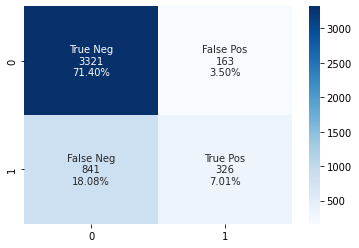

sensitivity : 0.27934875749785776, specificity : 0.9532146957520092, PPV : 0.6666666666666666, NPV : 0.7979336857280154


In [43]:
prediction_analyse(X_test, Y_test)

# CVD

## * Train

In [44]:
Y = data[:, 30:31]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
(6976, 22)


In [45]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [46]:
decision_tree.pretty_print()

|--- PREVHYP = 0.0 else  1.0
|---|--- SYSBP <= 121.0 
|---|---|--- SYSBP <= 113.0 
|---|---|---|--- TIME <= 1914.0 
|---|---|---|---|--- BMI <= 24.85 
|---|---|---|---|---|--- HDLC <= 69.0 value 0.0 else 1.0
|---|---|---|---|---|--- AGE <= 62.0 value 0.0 else 1.0
|---|---|---|---|--- GLUCOSE <= 128.0 value 0.0 else 1.0
|---|---|---|--- TIME <= 2238.0 
|---|---|---|---|--- SEX = 1.0 value 0.0
|---|---|---|---|---|--- LDLC <= 227.0 value 1.0 else 0.0
|---|---|---|---|--- SEX = 1.0 else  0.0
|---|---|---|---|---|--- HEARTRTE <= 90.0 value 0.0 else 1.0
|---|---|--- SYSBP <= 131.0 
|---|---|---|--- TIME <= 2309.0 value 1.0
|---|---|---|---|--- DIABP <= 87.0 else  1.0
|---|---|---|---|---|--- BMI <= 26.89 value 0.0 else 1.0
|---|---|---|--- TIME <= 4201.0 
|---|---|---|---|--- SYSBP <= 144.0 value 1.0
|---|---|---|---|---|--- DIABP <= 69.0 value 0.0 else 1.0
|---|---|---|---|--- SYSBP <= 138.0 value 1.0
|---|---|---|---|---|--- TIME <= 4469.0 value 1.0 else 0.0


## * Test

accuracy ==> 0.8241238443345517


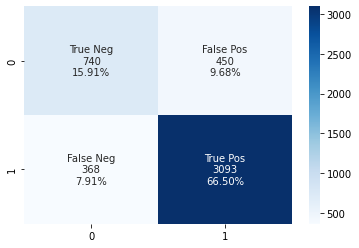

sensitivity : 0.8936723490320716, specificity : 0.6218487394957983, PPV : 0.8729889923793396, NPV : 0.6678700361010831


In [47]:
prediction_analyse(X_test, Y_test)

# HYPERTEN

## * Train

In [48]:
Y = data[:, 31:32]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=42)
print(Y)
print(X_train.shape)

[[8766.]
 [8766.]
 [8766.]
 ...
 [8766.]
 [8766.]
 [8766.]]
(6976, 22)


In [49]:
decision_tree = DecisionTree(max_depth=DEPTH)
decision_tree.fit(X_train, Y_train, x_col_names=x_col_names)

In [50]:
decision_tree.pretty_print()

|--- PREVAP = 0.0 value 8766.0
|---|--- TIME <= 1972.0 value 0.0
|---|---|--- TIME <= 4367.0 
|---|---|---|--- AGE <= 56.0 else  0.0
|---|---|---|---|--- HEARTRTE <= 77.0 else  294.0
|---|---|---|---|---|--- TOTCHOL <= 244.0 value 1811.0 else 0.0
|---|---|---|--- GLUCOSE <= 77.0 
|---|---|---|---|--- HDLC <= 48.0 else  1096.0
|---|---|---|---|---|--- PREVMI = 0.0 value 0.0 else 391.0
|---|---|---|---|--- HEARTRTE <= 62.0 
|---|---|---|---|---|--- AGE <= 65.0 value 1800.0 else 0.0
|---|---|---|---|---|--- TIME <= 4384.0 value 0.0 else 4025.0


## * Test

In [51]:
prediction_analyse(X_test, Y_test)

accuracy ==> 0.6164265749301225


ValueError: `data` and `annot` must have same shape.